In [1]:
import json
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score
from plotly import graph_objects as go
from collections import Counter
from math import sin, cos, sqrt, atan2, radians, isnan
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
items = pd.read_csv("data/items-translated.csv")
item_categories = pd.read_csv("data/item_categories-translated.csv")
shops = pd.read_csv("data/shops-translated.csv")
train = pd.read_csv("data/sales_train.csv")
test = pd.read_csv("data/test.csv")
russian_city_rank = eval(open("data/russia_city_rank_by_population.txt").readline())

In [3]:
city_rank_dict = dict(zip(russian_city_rank, list(range(len(russian_city_rank)))))

In [4]:
item_categories

,item_category_id,item_category_name
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2
2,2,Accessories - PS3
3,3,Accessories - PS4
4,4,Accessories - PSP
...,...,...
79,79,Office
80,80,Official - Tickets
81,81,Clean carriers (spire)
82,82,Clean media (piece)


In [5]:
items.item_category_id.nunique()

84

In [6]:
print("Number of shops", len(shops))
shops.head()

Number of shops 60


,shop_id,shop_name
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### No Missing values, just need to feature engineer data

## Outlier Analysis
- Item count being negative indicates the overall sells per day of that store is less than 0
- Item price being negative is observed in only one case, so ignoring that

In [9]:
train = train[(train.item_price > 0) & (train.item_cnt_day > 0)]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


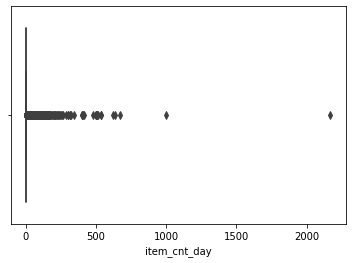

In [10]:
sns.boxplot(train.item_cnt_day)

In [11]:
train[train["item_cnt_day"]>800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


- Remove all entries that are outliers

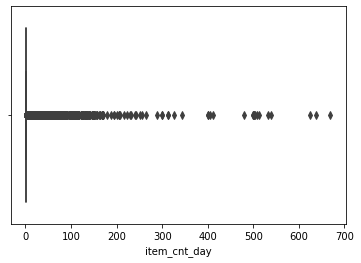

In [12]:
train = train[train.item_cnt_day < 800]
sns.boxplot(train.item_cnt_day)

0.07


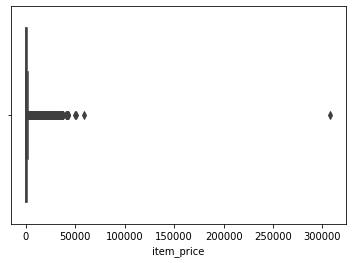

In [13]:
sns.boxplot(train.item_price)
print(min(train.item_price))

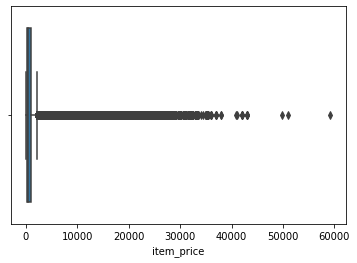

In [14]:
train = train[train.item_price < 100000]
sns.boxplot(train.item_price)

- Scaling of data for item_cnt_day or prices is **not required**, as they themselves indicate the scale.

## Add category_name, shop_name to total dataframe

In [15]:
item_categories.head()

,item_category_id,item_category_name
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2
2,2,Accessories - PS3
3,3,Accessories - PS4
4,4,Accessories - PSP


In [16]:
item_category_dict = dict(zip(items["item_id"], items["item_category_id"]))
train["category_id"] = train["item_id"].map(item_category_dict)
test["category_id"] = test["item_id"].map(item_category_dict)

shop_name_dict = dict(zip(shops["shop_id"], shops["shop_name"]))
train["shop_name"] = train["shop_id"].map(shop_name_dict)
test["shop_name"] = test["shop_id"].map(shop_name_dict)

category_name_dict = dict(zip(item_categories["item_category_id"], item_categories["item_category_name"]))
train["category_name"] = train["category_id"].map(category_name_dict)
test["category_name"] = test["category_id"].map(category_name_dict)

# Convert all strings to lower case
train["shop_name"] = train.shop_name.str.lower()
train["category_name"] = train.category_name.str.lower()
test["shop_name"] = test.shop_name.str.lower()
test["category_name"] = test.category_name.str.lower()

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id,shop_name,category_name
0,02.01.2013,0,59,22154,999.00,1.0,37,"yaroslavl shopping center ""altair""",cinema - blu-ray
1,03.01.2013,0,25,2552,899.00,1.0,58,"moscow trk ""atrium""",music - vinyl
3,06.01.2013,0,25,2554,1709.05,1.0,58,"moscow trk ""atrium""",music - vinyl
4,15.01.2013,0,25,2555,1099.00,1.0,56,"moscow trk ""atrium""",music - cd of branded production
5,10.01.2013,0,25,2564,349.00,1.0,59,"moscow trk ""atrium""",music - musical video


In [17]:
train[["city", "shop_name"]] = train.shop_name.str.split(" ", expand=True, n=1)
test[["city", "shop_name"]] = test.shop_name.str.split(" ", expand=True, n=1)

train[["category_name", "sub_category_name"]] = train.category_name.str.split(" - ", expand=True, n=1)
test[["category_name", "sub_category_name"]] = test.category_name.str.split(" - ", expand=True, n=1)

# Fill empty sub_category_name & category_name by no_sub_cat
train["sub_category_name"] = train["sub_category_name"].fillna("no_sub_cat")
test["sub_category_name"] = test["sub_category_name"].fillna("no_sub_cat")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id,shop_name,category_name,city,sub_category_name
0,02.01.2013,0,59,22154,999.00,1.0,37,"shopping center ""altair""",cinema,yaroslavl,blu-ray
1,03.01.2013,0,25,2552,899.00,1.0,58,"trk ""atrium""",music,moscow,vinyl
3,06.01.2013,0,25,2554,1709.05,1.0,58,"trk ""atrium""",music,moscow,vinyl
4,15.01.2013,0,25,2555,1099.00,1.0,56,"trk ""atrium""",music,moscow,cd of branded production
5,10.01.2013,0,25,2564,349.00,1.0,59,"trk ""atrium""",music,moscow,musical video


In [37]:
total = pd.concat([train, test])
train_len = len(train)
le = LabelEncoder()

le_shop_name = le.fit_transform(total["shop_name"])
train["shop_label"] = le_shop_name[:train_len]
test["shop_label"] = le_shop_name[train_len:]

le_city = total["city"].map(city_rank_dict)
le_city = pd.Series(le_city).fillna(400).tolist()
train["city_label"] = le_city[:train_len]
test["city_label"] = le_city[train_len:]

le_cat_name = le.fit_transform(total["category_name"])
train["category_label"] = le_cat_name[:train_len]
test["category_label"] = le_cat_name[train_len:]

le_sub_cat_name = le.fit_transform(total["sub_category_name"])
train["sub_category_label"] = le_sub_cat_name[:train_len]
test["sub_category_label"] = le_sub_cat_name[train_len:]

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id,shop_name,category_name,city,sub_category_name,shop_label,city_label,category_label,sub_category_label,revenue
0,02.01.2013,0,59,22154,999.00,1.0,37,"shopping center ""altair""",cinema,yaroslavl,blu-ray,16,26.0,3,9,999.00
1,03.01.2013,0,25,2552,899.00,1.0,58,"trk ""atrium""",music,moscow,vinyl,49,0.0,12,57,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,58,"trk ""atrium""",music,moscow,vinyl,49,0.0,12,57,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,56,"trk ""atrium""",music,moscow,cd of branded production,49,0.0,12,15,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,59,"trk ""atrium""",music,moscow,musical video,49,0.0,12,38,349.00


## Group train data by Month

In [38]:
# Mean is used as opposed to Median, because Mean captures the sudden increase of decrease in prices 
# which could have happened month based, like End of Season Sale etc.
group_col = ['item_id', 'shop_id', 'date_block_num', 'shop_label', 'category_label', 'city_label', 'sub_category_label']
month_wise = train.groupby(by=group_col).agg({'item_price':np.mean, 'item_cnt_day': sum}).reset_index()
month_wise

,item_id,shop_id,date_block_num,shop_label,category_label,city_label,sub_category_label,item_price,item_cnt_day
0,0,54,20,56,3,77.0,25,58.0,1.0
1,1,55,15,53,19,400.0,32,4490.0,2.0
2,1,55,18,53,19,400.0,32,4490.0,1.0
3,1,55,19,53,19,400.0,32,4490.0,1.0
4,1,55,20,53,19,400.0,32,4490.0,1.0
...,...,...,...,...,...,...,...,...,...
1608219,22168,12,8,12,10,400.0,28,799.0,1.0
1608220,22168,16,1,0,10,400.0,28,799.0,1.0
1608221,22168,42,1,33,10,400.0,28,799.0,1.0
1608222,22168,43,2,38,10,400.0,28,798.5,1.0


#### Create Item price dictionary for test data {item_id: item_price}

In [39]:
avg_item_price = month_wise.groupby('item_id').agg({'item_price': 'mean'}).reset_index()
item_price_dict = dict(zip(avg_item_price.item_id, avg_item_price.item_price))

## Analysis of test data

In [40]:
test.count()

ID                    214200
shop_id               214200
item_id               214200
category_id           214200
shop_name             214200
category_name         214200
city                  214200
sub_category_name     214200
shop_label            214200
city_label            214200
category_label        214200
sub_category_label    214200
revenue               214200
item_price            214200
dtype: int64

#### Check if any shop-id or item-id is not part of the data

In [41]:
shop_id = test["shop_id"]
item_id = test["item_id"]

num_shops = sum([1 for x in shop_id if not 0 < x < 60])
print("Number of shops not present in training data are", num_shops)

num_items = sum([1 for x in shop_id if not 0 < x < 22169])
print("Number of items not present in training data are", num_items)

Number of shops not present in training data are 0
Number of items not present in training data are 0


#### Check if any (shop_id, item_id) combination is not present in train data

In [42]:
train_my_id = train["shop_id"].astype(str) + "_" + train["item_id"].astype(str)
test_my_id = test["shop_id"].astype(str) + "_" + test["item_id"].astype(str)

len(set(test_my_id).difference(set(train_my_id)))

102796

In [43]:
items.count()

item_id             22170
item_name           22170
item_category_id    22170
dtype: int64

In [44]:
# Compute shop's avg.revenue such highest importance is given to latest month's revenue
train["revenue"] = train["item_price"] * train["item_cnt_day"]

# Group by shop_id, date_block_num and compute revenue
monthly_revenue = train.groupby(by=['shop_id', 'date_block_num']).agg({'revenue':sum}).reset_index()
monthly_revenue

# Compute average monthly revenue by using strategy similar to Exponential Moving Average.
"""
Ideally, factor is a value between (0,1), calculated as follows
smoothing = 3 # Arbitrary
num_days = 30
factor = smoothing/(num_days+1) 

However, a factor of 0.9 is used because 0.9**33 is not a number that is too small. Making each a valid entry.
"""
factor = 0.9

total_months = max(monthly_revenue["date_block_num"])

def get_monthly_revenue(x):
    revenue = x["revenue"]
    month_num = x["date_block_num"]
    return revenue * (factor ** (total_months - month_num))

# Now, average_revenue  = SUM[factor ** (num_months - month) * revenue]/(Number of months)
monthly_revenue["derived_revenue"] = monthly_revenue.apply(lambda x: get_monthly_revenue(x), axis=1) 


shops_revenue = monthly_revenue.groupby('shop_id').agg({'derived_revenue':sum}).reset_index()
shops_revenue.to_csv("shops_revenue.csv", index=False)
shops_revenue_dict = dict(zip(shops_revenue["shop_id"], shops_revenue["derived_revenue"]))
shops_revenue.head()

,shop_id,derived_revenue
0,0,2.177206e+05
1,1,1.059455e+05
2,2,1.297901e+07
3,3,9.205385e+06
4,4,1.000507e+07


In [45]:
# Add revenue for test entries
test["revenue"] = test["shop_id"].map(shops_revenue_dict)
test["revenue"] = test["revenue"].fillna(-1)

# Add item price as column in test data
test["item_price"] = test["item_id"].map(item_price_dict)
test["item_price"] = test["item_price"].fillna(-1)

In [46]:
num_shops, num_items = len(shops), len(items)
# This matrix will have the number of items sold overall (33 months)
shop_item_count_matrix = [[0]*num_shops for i in range(num_items)] # Shape: 22170 x 60
item_count_dict = dict(zip(train_my_id, train["item_cnt_day"].to_list())) # {'shop_item': num_items}

for k, v in item_count_dict.items():
    shop, item = list(map(int, k.split("_")))
    shop_item_count_matrix[item][shop] += v

print(pd.DataFrame(shop_item_count_matrix))

        0    1    2    3    4    5    6    7    8    9   ...   50   51   52  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
22165  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22166  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22167  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...  1.0  1.0  1.0   
22168  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22169  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

        53   54   55   56   57   58   59  
0      0

In [47]:
month_wise

,item_id,shop_id,date_block_num,shop_label,category_label,city_label,sub_category_label,item_price,item_cnt_day
0,0,54,20,56,3,77.0,25,58.0,1.0
1,1,55,15,53,19,400.0,32,4490.0,2.0
2,1,55,18,53,19,400.0,32,4490.0,1.0
3,1,55,19,53,19,400.0,32,4490.0,1.0
4,1,55,20,53,19,400.0,32,4490.0,1.0
...,...,...,...,...,...,...,...,...,...
1608219,22168,12,8,12,10,400.0,28,799.0,1.0
1608220,22168,16,1,0,10,400.0,28,799.0,1.0
1608221,22168,42,1,33,10,400.0,28,799.0,1.0
1608222,22168,43,2,38,10,400.0,28,798.5,1.0


In [48]:
test

,ID,shop_id,item_id,category_id,shop_name,category_name,city,sub_category_name,shop_label,city_label,category_label,sub_category_label,revenue,item_price
0,0,5,5037,19,"shopping and entertainment center ""marmalade""",games,vologda,ps3,15,62.0,9,45,1.139571e+07,1961.217527
1,1,5,5320,55,"shopping and entertainment center ""marmalade""",music,vologda,cd of local production,15,62.0,12,16,1.139571e+07,-1.000000
2,2,5,5233,19,"shopping and entertainment center ""marmalade""",games,vologda,ps3,15,62.0,9,45,1.139571e+07,844.516003
3,3,5,5232,23,"shopping and entertainment center ""marmalade""",games,vologda,xbox 360,15,62.0,9,59,1.139571e+07,792.527697
4,4,5,5268,20,"shopping and entertainment center ""marmalade""",games,vologda,ps4,15,62.0,9,46,1.139571e+07,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,55,"tc ""parkhaus""",music,samara,cd of local production,35,8.0,12,16,9.892495e+06,180.699928
214196,214196,45,16188,64,"tc ""parkhaus""",gifts,samara,board games,35,8.0,10,12,9.892495e+06,1256.975000
214197,214197,45,15757,55,"tc ""parkhaus""",music,samara,cd of local production,35,8.0,12,16,9.892495e+06,198.336478
214198,214198,45,19648,40,"tc ""parkhaus""",cinema,samara,dvd,35,8.0,3,25,9.892495e+06,97.865116


In [49]:
reg = XGBRegressor()
parameters = {'n_estimators': [100], 'max_depth':[5]}
grid_search = GridSearchCV(estimator=reg, param_grid=parameters, cv=5)

In [50]:
# Add features from Item name, 
# figure out a way to add item_price (not present in test set)

feature_columns = ['revenue', 'shop_label', 'city_label', 'category_label', 'sub_category_label', 'item_price']
X = train[feature_columns]
y = train["item_cnt_day"]

In [52]:
# grid_search.fit(X, y)
# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters=grid_search.best_estimator_.get_params()
# best_parameters

In [53]:
best_max_depth = 5
best_n_estimator = 100

In [62]:
reg = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimator)
reg.fit(X,y)
y_pred = reg.predict(test[feature_columns])
test["item_cnt_month"] = y_pred

[15:51:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
test.head()

,ID,shop_id,item_id,category_id,shop_name,category_name,city,sub_category_name,shop_label,city_label,category_label,sub_category_label,revenue,item_price,item_cnt_month
0,0,5,5037,19,"shopping and entertainment center ""marmalade""",games,vologda,ps3,15,62.0,9,45,1.139571e+07,1961.217527,342.323517
1,1,5,5320,55,"shopping and entertainment center ""marmalade""",music,vologda,cd of local production,15,62.0,12,16,1.139571e+07,-1.000000,692.091309
2,2,5,5233,19,"shopping and entertainment center ""marmalade""",games,vologda,ps3,15,62.0,9,45,1.139571e+07,844.516003,649.600220
3,3,5,5232,23,"shopping and entertainment center ""marmalade""",games,vologda,xbox 360,15,62.0,9,59,1.139571e+07,792.527697,656.318176
4,4,5,5268,20,"shopping and entertainment center ""marmalade""",games,vologda,ps4,15,62.0,9,46,1.139571e+07,-1.000000,694.562622


In [64]:
np.mean(test.item_cnt_month)

598.8229

In [65]:
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

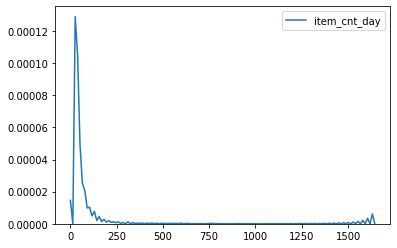

In [66]:
sns.kdeplot(month_wise.item_cnt_day)

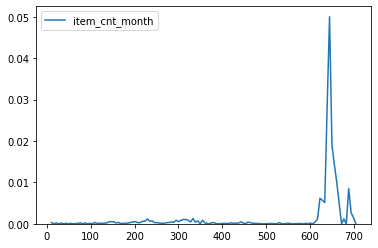

In [67]:
sns.kdeplot(test.item_cnt_month)

In [68]:
train[train.city_label.isna()]["city"].value_counts()

Series([], Name: city, dtype: int64)

In [69]:
reg.feature_importances_

array([0.52343714, 0.00088385, 0.00545308, 0.01677677, 0.00199041,
       0.45145878], dtype=float32)

In [70]:
feature_columns

['revenue',
 'shop_label',
 'city_label',
 'category_label',
 'sub_category_label',
 'item_price']

In [71]:
test.city.value_counts()

moscow          35700
yakutsk         10200
novosibirsk     10200
tyumen          10200
voronezh        10200
samara          10200
ufa             10200
vologda          5100
kazan            5100
online           5100
tomsk            5100
omsk             5100
zhukovsky        5100
chekhov          5100
krasnoyarsk      5100
colosseum        5100
kursk            5100
nizhny           5100
kaluga           5100
rostovnadonu     5100
rostovnadon      5100
balashikha       5100
yaroslavl        5100
digital          5100
spb              5100
surgut           5100
volzhsky         5100
adygea           5100
sergiev          5100
n.novgorod       5100
Name: city, dtype: int64

In [72]:
from sklearn.tree import export_graphviz
# Export as dot file
estimator = reg.estimators_[5]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'XGBRegressor' object has no attribute 'estimators_'